# Face Recognition using Siamese Network

### Install and Import Dependencies

In [ ]:
# Install dependencies
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [2]:
# Import dependencies
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, Input, Flatten, MaxPooling2D

### Set GPU Growth

In [4]:
# Avoid OOM (Out of Memory) errors by setting GPU Memory Consumption Growth
# GPU stands for Graphical Processing Unit
# gpus = tf.config.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [48]:
# Number of physical devices in the machine
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [46]:
# Number of CPU's in the machine
cpus = tf.config.list_physical_devices('CPU')
len(cpus)

1

In [44]:
# Printing the number of CPU's in the machine
for cpu in cpus:
    print(cpu)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [5]:
# Number of GPU's in the machine
len(gpus)

0

In [49]:
# Printing the GPU's in the machine
for gpu in gpus:
    print(gpu)

### Create Folder Structures

In [7]:
# POS_PATH for positive image path which has the correct images
POS_PATH = os.path.join('data', 'positive')

# NEG_PATH for negative image path which has incorrect images
NEG_PATH = os.path.join('data', 'negative')

# ANC_PATH for anchor image path which has the image to be tested against negative and positive images
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
# Make the directories
# 'makedirs' makes the directory from scratch that is it creates all the intermediate directories
# Like in this example it will create 'data' directory under which 'positive' directory whould be made
# So the complete path using 'makedirs' will look like 'data\positive\'
# Whereas 'mkdir' creates single sub-directory that is,
# it would make just the 'positive' directory and not its super directory 'data'
# The complete path using 'mkdir' would look like 'positive\'
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [8]:
# Printing the path
print(POS_PATH)
print(NEG_PATH)
print(ANC_PATH)

data\positive
data\negative
data\anchor


### Collect Negatives from Labelled Faces in the Wild Dataset

In [9]:
# Link to labelled faces in the wild dataset (Negative Input) : http://vis-www.cs.umass.edu/lfw/#download
# Uncompress Tar GZ labelled faces in the wild dataset
!tar -xf lfw.tgz

In [10]:
# Move 'lfw' images to 'data\Negative'
# The first two lines of code generates the entire set of images from each files in each directory
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        
#         EX_PATH for existing path of the labelled images in the wild dataset
        EX_PATH = os.path.join('lfw', directory, file)
        
#         NEW_PATH for the path of 'Negative' directory in 'data' directory
        NEW_PATH = os.path.join(NEG_PATH, file)
        
#         Moving all labelled images into NEW_PATH
        os.replace(EX_PATH, NEW_PATH)

### Collect Positives and Anchors using Webcam

In [36]:
# Import uuid library to generate unique names to each image
# uuid stands for Univerally Unique IDentifier
import uuid

In [54]:
# Generation of unique filename via different forms
print('{}.jpg'.format(uuid.uuid1()))
print('{}.jpg'.format(uuid.uuid4()))

# Just to check how the unique filename is generated using 'uuid' along with the path
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

b88d6d9f-3768-11ee-8a0b-991a02abb77d.jpg
18c08d16-904b-47f8-9c17-123316ffc3da.jpg


'data\\anchor\\b88d6da0-3768-11ee-a7b8-991a02abb77d.jpg'

In [37]:
# Establish a connection to the Webcam
# Here, '0' is the device's webcam's location
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
#     Cut down frame to 250x250px
    frame = frame[170:170+250, 220:220+250, :]
    
#     Collect anchor images
#     On clicking 'a' on keyboard an anchor image would be created and stored in the desired directory
    if cv2.waitKey(1) & 0xFF == ord('a'):
#         Create the unique anchor image file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         Store the image in respective directory (Write out anchor image)
        cv2.imwrite(imgname, frame)
    
#     Collect positive images
#     On clicking 'p' on keyboard a positive image would be created and stored in the desired directory
    if cv2.waitKey(1) & 0xFF == ord('p'):
#         Create the unique positive image file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         Store the image in respective directory (Write out positive image)
        cv2.imwrite(imgname, frame)
    
#     Show Image back to screen
    cv2.imshow("Image Collection", frame)
    
#     Breaking gracefully
#     On clicking 'q' on keyboard, the looping would break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# Release the Webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

(250, 250, 3)


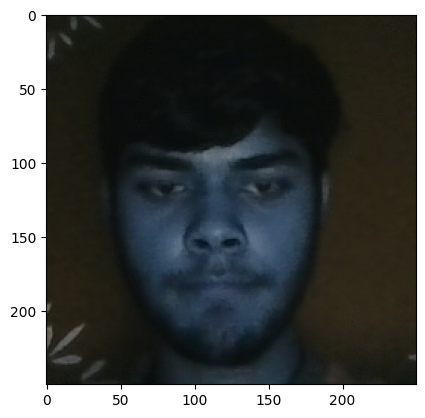

In [38]:
# Print the frame shape
print(frame.shape)
plt.imshow(frame)
plt.show()
# Image slicing
# print(frame[170:170+250, 220:220+250, :].shape)
# plt.imshow(frame[170:170+250, 220:220+250, :])
# plt.show()
# print(frame[250:250+250, 120:120+250, :].shape)
# plt.imshow(frame[250:250+250, 120:120+250, :])
# plt.show()

In [8]:
import uuid
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\901c0253-3449-11ee-8546-991a02abb77d.jpg'

In [11]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [12]:
plt.imshow(frame[120:120+250,200:200+250, :])

NameError: name 'frame' is not defined